In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

'[' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [4]:
search_images_ddg?

Signature: search_images_ddg(term, max_images=200)
Docstring: Search for `term` with DuckDuckGo and return a unique urls of about `max_images` images
File:      c:\users\jared\onedrive\desktop\fastbook\fastai\lib\site-packages\fastbook\__init__.py
Type:      function

In [6]:
ims = search_images_ddg('grizzly bear')
len(ims)

200

In [8]:
dest = 'downloaded_images/grizzly.jpg'
download_url(ims[0], dest)

Path('downloaded_images/grizzly.jpg')

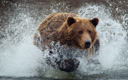

In [9]:
# Opening example of image to ensure that correct images are downloaded

im = Image.open(dest)
im.to_thumb(128,128)

In [55]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [56]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} bear', max_images=300)
        download_images(dest, urls=results)

In [57]:
# Check total number of images downloaded (both valid and invalid)
fns = get_image_files(path)
fns

(#808) [Path('bears/black/00ba7b92-a039-4acf-8ada-1225dde944dd.jpg'),Path('bears/black/0199416a-3034-4040-bc8d-4980cbdb8a0c.jpg'),Path('bears/black/032f47b2-a968-4c44-acde-c136c87f00a4.jpg'),Path('bears/black/04640d9d-0a1c-4eeb-a480-ec2f0727c836.jpg'),Path('bears/black/0495a5da-1790-49b9-ab99-81d69796cb1c.jpg'),Path('bears/black/0512964f-47af-444a-adf9-18ecce205da4.jpg'),Path('bears/black/07199466-5efd-4042-93aa-f653c9fc1840.jpeg'),Path('bears/black/074f94a6-c437-44c4-9925-026311fe8b9e.jpg'),Path('bears/black/07aa3b5c-f90a-473a-8ad7-f7ae4ff3f031.JPG'),Path('bears/black/0b710fcd-4807-486b-8f63-61f355ec1394.jpg')...]

In [58]:
# Important step to ensure that all images are valid in order for the model to be trained properly
failed = verify_images(fns)
failed

(#74) [Path('bears/black/074f94a6-c437-44c4-9925-026311fe8b9e.jpg'),Path('bears/black/5d9eabd2-59c3-4654-9929-3c2a023413c2.jpg'),Path('bears/black/6c934be4-ee31-4e28-ad97-59e4ed604dc0.jpg'),Path('bears/black/79b08b8d-b4cf-40b6-93af-1b551e2c8c3e.jpg'),Path('bears/black/7ecc97ec-e322-47a2-94ab-eea0514c6f68.jpg'),Path('bears/black/89c8347e-dfa3-40da-b8a7-6510f6704bcb.jpg'),Path('bears/black/9cba3fe6-db72-4483-8dcc-5995623aef36.JPG'),Path('bears/black/aa5fcaa4-4e79-4c52-880c-f835b4ddfcad.jpg'),Path('bears/black/ac47ee01-b3cd-456a-b4ca-d7cf6caa5afe.jpg'),Path('bears/black/b1b8492d-8762-43d0-a888-8452dd3962f8.jpg')...]

In [59]:
# Remove failed images from the dataset
failed.map(Path.unlink);

In [60]:
# Sanity check to ensure that all failed images are removed
fns = get_image_files(path)
fns

(#734) [Path('bears/black/00ba7b92-a039-4acf-8ada-1225dde944dd.jpg'),Path('bears/black/0199416a-3034-4040-bc8d-4980cbdb8a0c.jpg'),Path('bears/black/032f47b2-a968-4c44-acde-c136c87f00a4.jpg'),Path('bears/black/04640d9d-0a1c-4eeb-a480-ec2f0727c836.jpg'),Path('bears/black/0495a5da-1790-49b9-ab99-81d69796cb1c.jpg'),Path('bears/black/0512964f-47af-444a-adf9-18ecce205da4.jpg'),Path('bears/black/07199466-5efd-4042-93aa-f653c9fc1840.jpeg'),Path('bears/black/07aa3b5c-f90a-473a-8ad7-f7ae4ff3f031.JPG'),Path('bears/black/0b710fcd-4807-486b-8f63-61f355ec1394.jpg'),Path('bears/black/0ce48a4e-3333-4e5d-9992-af9ccb5e8992.jpg')...]

## From Data to DataLoaders

#### In the below example, instead of following the usual flow of cleaning data before training the model, the model is first trained and then used to clean the data

In [61]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # Seed value is set to ensure reproducibility
    get_y=parent_label,
    item_tfms=Resize(128))

In [62]:
dls = bears.dataloaders(path)

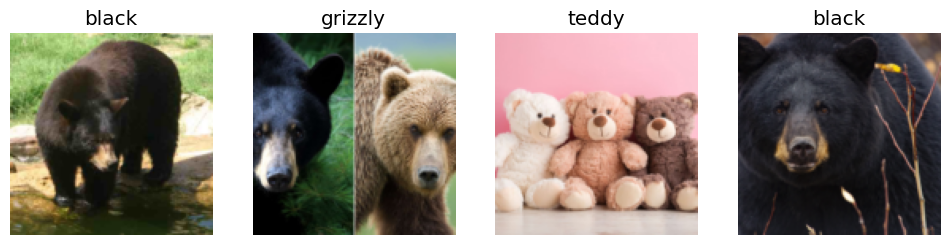

In [64]:
# Method to ensure that images are loaded correctly
dls.valid.show_batch(max_n=4, nrows=1)

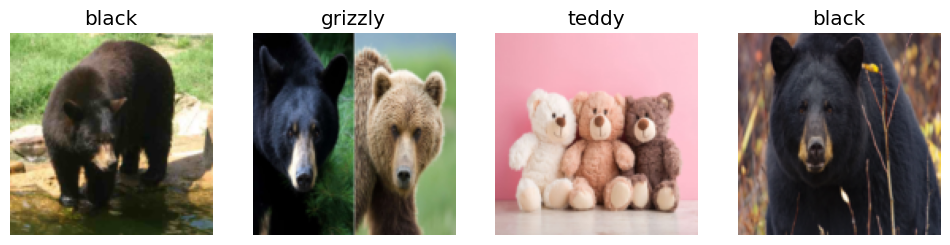

In [65]:
# Using squish method for transformation
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

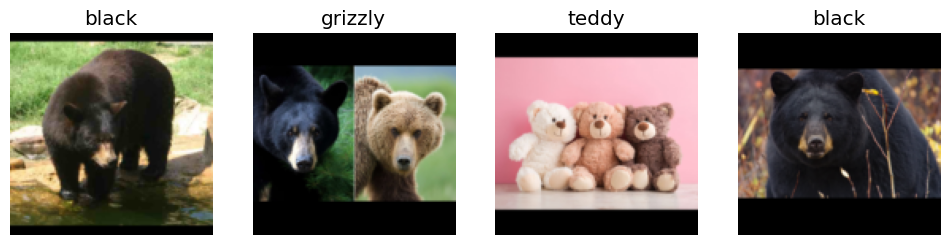

In [66]:
# Using pad method for transformation
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

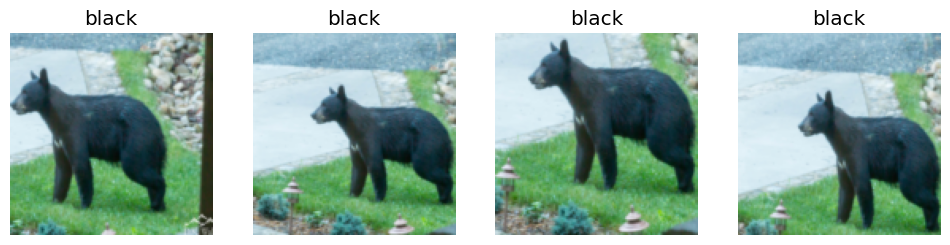

In [67]:
# Using random crop method for transformation
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

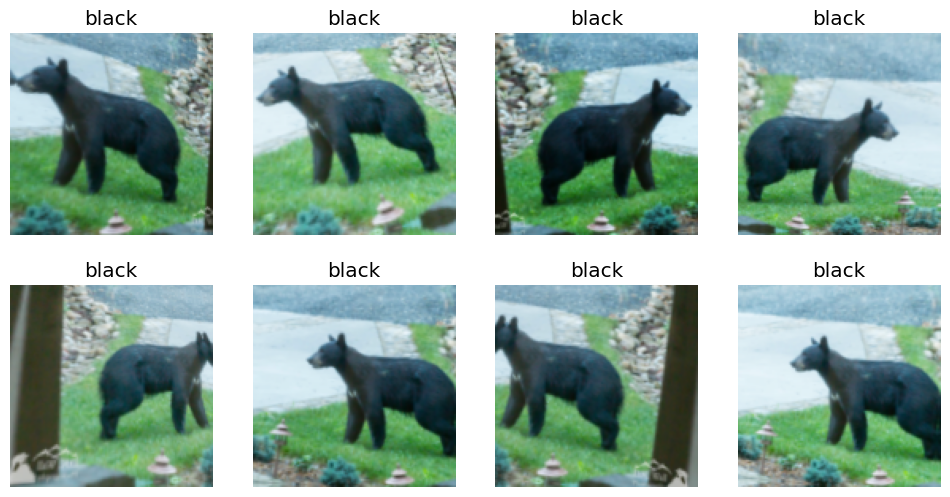

In [68]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms())
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [69]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [70]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.104485,0.208905,0.068493,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.362694,0.208624,0.054795,00:15
1,0.272292,0.221379,0.061644,00:15
2,0.225982,0.236971,0.047945,00:15
3,0.185346,0.235180,0.047945,00:16


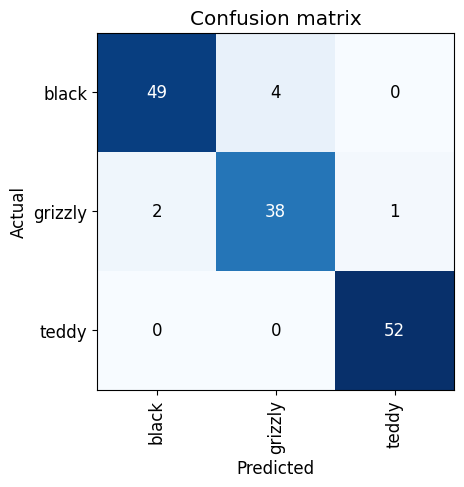

In [71]:
# Use confusion matrix for easy human interpretation
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

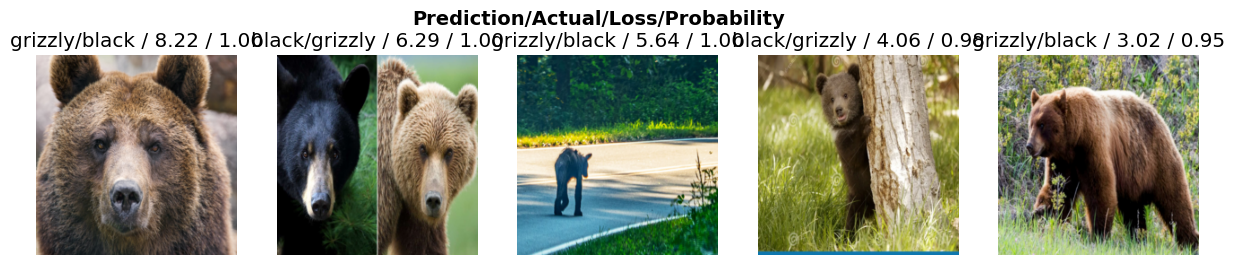

In [73]:
interp.plot_top_losses(5, nrows=1)

In [74]:
cleaner = ImageClassifierCleaner(learn)
cleaner

c:\Users\jared\OneDrive\Desktop\fastbook\fastai\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [75]:
# Clean up the dataset by removing images that are misclassified
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [76]:
learn.export()

In [77]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [78]:
learn_inf = load_learner(path/'export.pkl')

In [80]:
learn_inf.predict('downloaded_images/grizzly.jpg')

('grizzly', tensor(1), tensor([1.0835e-05, 9.9998e-01, 9.9327e-06]))

In [81]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

### Creating a Notebook App from the Model

In [82]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [84]:
btn_upload = SimpleNamespace(data = ['downloaded_images/grizzly.jpg'])

In [85]:
img = PILImage.create(btn_upload.data[-1])

In [86]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [87]:
pred,pred_idx,probs = learn_inf.predict(img)

In [88]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

In [89]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

IndexError: list index out of range

In [90]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [91]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [92]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning Your Notebook into a Real App

In [ ]:
#hide
# !pip install voila
# !jupyter serverextension enable --sys-prefix voila 